In [ ]:
#Copyright 2021 Google LLC
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    https://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and 
#limitations under the License.

In [ ]:
!pip install torchcsprng==0.1.3+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install opacus

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.6 MB 423 kB/s 
     |████████████████████████████████| 577.3 MB 4.1 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.7.0+cu92 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.0+cu92 which is incompatible.
     |████████████████████████████████| 114 kB 8.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import random
import copy
import time
import math
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer, required
from opacus.privacy_engine import PrivacyEngine
from opacus.utils import stats
from opacus.utils.tensor_utils import calc_sample_norms
from tqdm import tqdm
import pickle 

warnings.filterwarnings('ignore')
#devicestring = "cpu"
devicestring = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(devicestring)
print("Running on "+devicestring)

Running on cpu


In [ ]:
def test(model, train_loader, test_loader, device, prnt):
    model.eval()
    criterion = torch.nn.MSELoss(size_average=True)
    
    losses = []

    with torch.no_grad():
        for images, target in train_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            preds = torch.round(output).cpu().numpy()
            loss = criterion(output, target)
            losses.append(loss.item())
            
    if prnt:
        print(f"\tTrain set:" f"Loss: {np.mean(losses):.6f} ")
    
    returnval = np.mean(losses)
    if prnt:
        losses = []

        with torch.no_grad():
            for images, target in test_loader:
                images = images.to(device)
                target = target.to(device)

                output = model(images)
                preds = torch.round(output).cpu().numpy()
                loss = criterion(output, target)
                losses.append(loss.item())

            print(f"\Test set:" f"Loss: {np.mean(losses):.6f} ")
    return returnval

Running on dimension 4500
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40


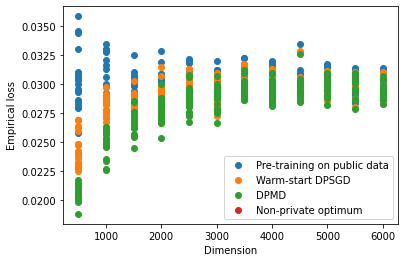

Running on dimension 4500
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 32.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40


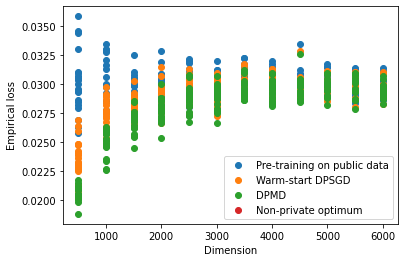

Running on dimension 4500
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40


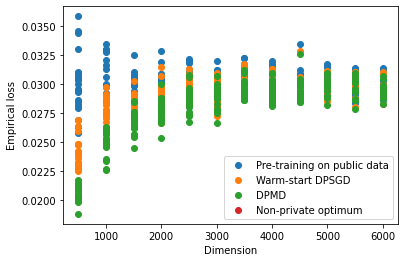

Running on dimension 5000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40


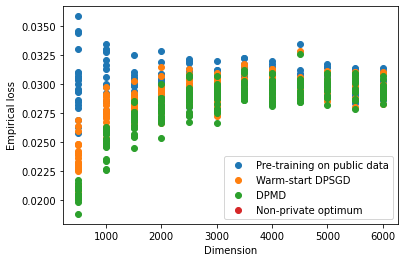

Running on dimension 5000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 32.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40


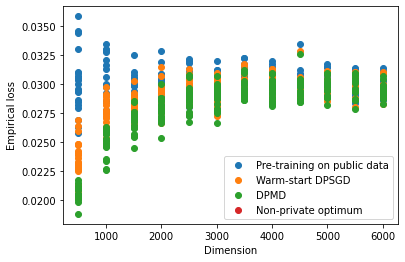

Running on dimension 5000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 32.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


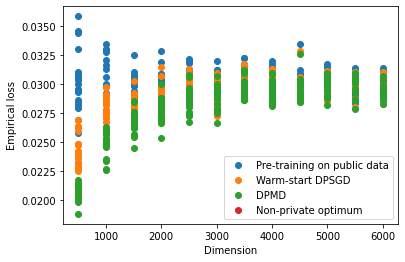

Running on dimension 5000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 4.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 32.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


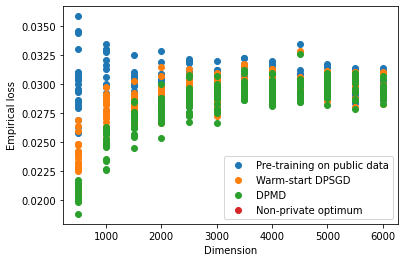

Running on dimension 5500
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


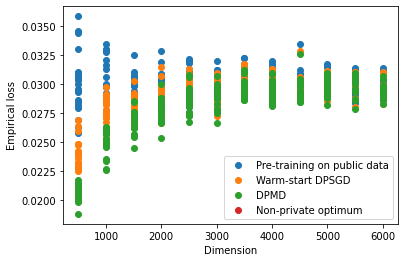

Running on dimension 5500
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


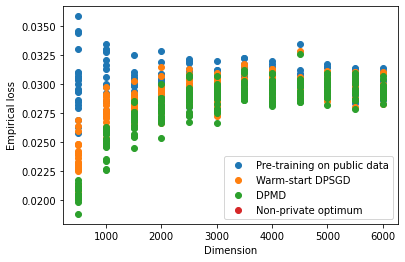

Running on dimension 5500
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


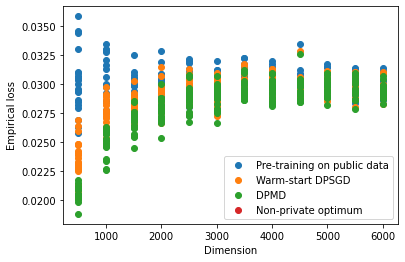

Running on dimension 5500
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40


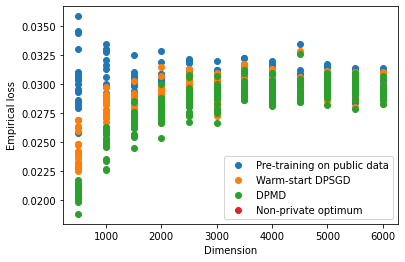

Running on dimension 6000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 1.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40


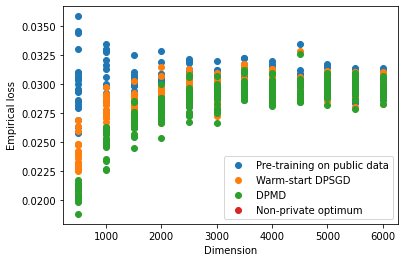

Running on dimension 6000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


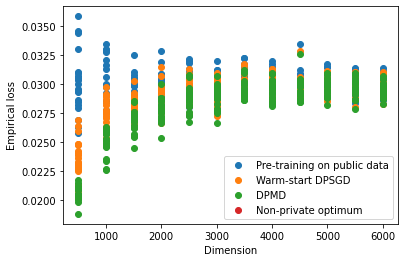

Running on dimension 6000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 1.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 16.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


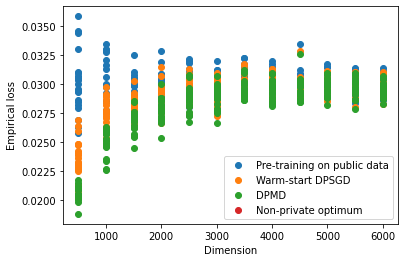

Running on dimension 6000
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
WSGD Best LR: 2.0, Clipping Norm: 1.0, Epochs: 40
Learning rate: 1.0, Clipping norm: 1.0
Learning rate: 2.0, Clipping norm: 1.0
Learning rate: 4.0, Clipping norm: 1.0
Learning rate: 8.0, Clipping norm: 1.0
Learning rate: 16.0, Clipping norm: 1.0
Learning rate: 32.0, Clipping norm: 1.0
Learning rate: 64.0, Clipping norm: 1.0
Learning rate: 128.0, Clipping norm: 1.0
CSGD Best LR: 32.0, Clipping Norm: 1.0, Epochs: 40
MD Best LR: 8.0, Clipping Norm: 1.0, Epochs: 40


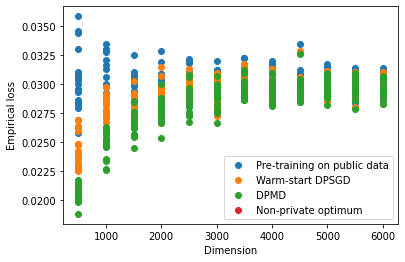

In [ ]:
DATA_PATH = "/content/drive/MyDrive/MDData/"

# For storing a fresh set of results
# pubresults = []
# csgdresults = []
# wsgdresults = []
# mdresults = []
# npresults = []

#For reloading results from pickle file
results = pickle.load(open(DATA_PATH+"LinRegResults.p", "rb"))
pubresults = results[0]
csgdresults = results[1]
wsgdresults = results[2] 
mdresults = results[3]
npresults = results[4] 

#Synthetic dataset generation

for dim in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]:
  while len([r for r in mdresults if r[0] == dim]) < 20:
    print("Running on dimension "+str(dim))
    ysd = 0.1
    privatesamples = 10000
    publicsamples = int(dim*3/2)
    testsamples = 5000
    targeteps = 1.0
    batch_size = privatesamples

    weight = np.random.normal(scale = 1.0, size = dim)
    bias = 0.0
    def gen_loader(samples, bs, save):
        #x = [np.concatenate((np.random.normal(scale = 1.0/np.sqrt(dim), size = int(dim/5)), np.random.normal(scale = 5.0/np.sqrt(dim), size = int(4*dim/5)))) for i in range(samples)]
        #x = [np.random.normal(scale = 1.0/np.sqrt(dim), size = dim) for i in range(samples)]
        x = [np.concatenate((np.random.choice([0, 1/20], size = int(dim/5), p = [1-(200/dim), 200/dim]),
                                np.random.choice([0, 1/20], size = int(4*dim/5), p = [1-(100/dim), 100/dim]))) for i in range(samples)]
        preds = [np.dot(weight, samp)+bias for samp in x]
        #print(np.mean(np.abs(preds)))
        y = [pred+np.random.normal(scale = ysd, size = 1) for pred in preds]
        opt = np.mean([(preds[i] - y[i])**2 for i in range(samples)])
        # if save:
        #    npresults.append([dim, opt])
        dataset = TensorDataset(torch.Tensor(x),torch.Tensor(y)) 
        return x, y, DataLoader(dataset, batch_size = bs, shuffle = True), opt 

    pubx, puby, publicfullloader, publicopt = gen_loader(publicsamples, publicsamples, False)
    privx, privy, privateloader, privateopt = gen_loader(privatesamples, batch_size, True)
    _, _, testloader, testopt = gen_loader(testsamples, batch_size, False)

    pubmat = np.transpose(np.array(pubx)).dot(np.array(pubx))/publicsamples + .01/dim * np.identity(dim)
    pubsol = torch.from_numpy(np.transpose(np.linalg.inv(np.transpose(np.array(pubx)).dot(np.array(pubx))).dot(np.transpose(np.array(pubx))).dot(puby)))
    w, v = np.linalg.eig(pubmat)
    mineig = min(w)
    pubmat = pubmat/mineig
    #print(sorted(w, reverse=True))
    # w = w/mineig
    # plt.plot(np.linspace(1, dim, dim), sorted(w))
    # plt.show()
    # print(sum([min(1.0, 1/eig) ** 2 for eig in w])/dim)


    #Linear regression network
    class Net(torch.nn.Module):
          def __init__(self):
            super(Net, self).__init__()
            self.linear = torch.nn.Linear(dim, 1, bias=False)

          def forward(self, x):
            y = self.linear(x)
            return y

    def lrnet():
        return Net()

    criterion = nn.MSELoss()
    PATH = DATA_PATH+"./mirrorLinReg.pt"

    #Compute and save exact public optimum
    model = lrnet()
    model = model.to(device)
    with torch.no_grad():
        model.linear.weight = nn.Parameter(pubsol.type(torch.FloatTensor))
    torch.save(model.state_dict(), PATH)
    trainloss = test(model, privateloader, testloader, device, False)
    pubresults.append([dim, trainloss])


    lrs = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
    norms = [1.0]
    epoch_nums = [40]

    #Benchmark: SGD on private data (from warm start / with public-based clipping)

    epochs = 40
    #model = Net()
    globalminloss = 999999
    bestparams = (None, None)
    for epochs in epoch_nums:
        for lr in lrs:
            for max_grad_norm in norms:
                model = lrnet()
                model.load_state_dict(torch.load(PATH))
                model = model.to(device)
                optimizer = optim.SGD(model.parameters(), lr = lr)
                accountant = PrivacyEngine(model, sample_rate = 1.0*batch_size/privatesamples, epochs = epochs,
                                            max_grad_norm = max_grad_norm, target_epsilon = targeteps, target_delta = .00001)
                accountant.attach(optimizer)

            #     print("Initial model:")
            #     test(model, privateloader, testloader, device)
                minloss = 999999.0

                for epoch in range(epochs):
                    model.train()
                    for i, data in enumerate(privateloader, 0):
                #         if i == 0:
                #             for ipub, datapub in enumerate(publicfullloader, 0):
                #                 model.zero_grad()
                #                 images, labels = datapub[0].to(device), datapub[1].to(device)
                #                 outputs = model(images)
                #                 loss = criterion(outputs, labels)
                #                 loss.backward()
                #                 #oldpubgrad = [param.grad.clone() for param in list(model.parameters())]
                #                 all_norms = calc_sample_norms(accountant.clipper._named_grad_samples(),
                #                                               flat = not accountant.clipper.norm_clipper.is_per_layer,)
                #                 batchmaxnorm = np.percentile(np.array(all_norms[0].tolist()), 90)
                #                 print(batchmaxnorm)
                #                 accountant.clipper.norm_clipper.flat_value = batchmaxnorm
                #                 accountant.max_grad_norm = batchmaxnorm

                        model.zero_grad()
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = model(images)
                #         reg = 0.0
                #         for param in model.parameters():
                #             reg += 0.5 * (param ** 2).sum()
                        loss = criterion(outputs, labels) #+ alpha * reg / 2.0
                        loss.backward()
                        optimizer.step()
                    trainloss = test(model, privateloader, testloader, device, False)
                    minloss = min(minloss, trainloss)
                print("Learning rate: "+str(lr)+", Clipping norm: "+str(max_grad_norm))
                #print("Epoch "+str(epoch+1))
                eps, _ = accountant.get_privacy_spent()
                #print("Epsilon: "+str(eps)+", Delta: "+str(accountant.target_delta))
                test(model, privateloader, testloader, device, False)
                # print("Loss: "+str(minloss)+", Accuracy: "+str(maxacc))
                if minloss < globalminloss:
                    globalminloss = minloss
                    bestparams = (lr, max_grad_norm, epochs)
    print("WSGD Best LR: "+str(bestparams[0])+", Clipping Norm: "+str(bestparams[1])+", Epochs: "+str(bestparams[2]))
    wsgdresults.append([dim, globalminloss])

    globalminloss = 999999
    bestparams = (None, None)
    for epochs in epoch_nums:
        for lr in lrs:
            for max_grad_norm in norms:
                model = lrnet()
                model = model.to(device)
                optimizer = optim.SGD(model.parameters(), lr = lr)
                accountant = PrivacyEngine(model, sample_rate = 1.0*batch_size/privatesamples, epochs = epochs,
                                            max_grad_norm = max_grad_norm, target_epsilon = targeteps, target_delta = .00001)
                accountant.attach(optimizer)

            #     print("Initial model:")
            #     test(model, privateloader, testloader, device)
                minloss = 999999.0

                for epoch in range(epochs):
                    model.train()
                    for i, data in enumerate(privateloader, 0):
                #         if i == 0:
                #             for ipub, datapub in enumerate(publicfullloader, 0):
                #                 model.zero_grad()
                #                 images, labels = datapub[0].to(device), datapub[1].to(device)
                #                 outputs = model(images)
                #                 loss = criterion(outputs, labels)
                #                 loss.backward()
                #                 #oldpubgrad = [param.grad.clone() for param in list(model.parameters())]
                #                 all_norms = calc_sample_norms(accountant.clipper._named_grad_samples(),
                #                                               flat = not accountant.clipper.norm_clipper.is_per_layer,)
                #                 batchmaxnorm = np.percentile(np.array(all_norms[0].tolist()), 90)
                #                 print(batchmaxnorm)
                #                 accountant.clipper.norm_clipper.flat_value = batchmaxnorm
                #                 accountant.max_grad_norm = batchmaxnorm

                        model.zero_grad()
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = model(images)
                #         reg = 0.0
                #         for param in model.parameters():
                #             reg += 0.5 * (param ** 2).sum()
                        loss = criterion(outputs, labels) #+ alpha * reg / 2.0
                        loss.backward()
                        optimizer.step()
                    trainloss = test(model, privateloader, testloader, device, False)
                    minloss = min(minloss, trainloss)
                print("Learning rate: "+str(lr)+", Clipping norm: "+str(max_grad_norm))
                #print("Epoch "+str(epoch+1))
                eps, _ = accountant.get_privacy_spent()
                #print("Epsilon: "+str(eps)+", Delta: "+str(accountant.target_delta))
                test(model, privateloader, testloader, device, False)
                # print("Loss: "+str(minloss)+", Accuracy: "+str(maxacc))
                if minloss < globalminloss:
                    globalminloss = minloss
                    bestparams = (lr, max_grad_norm, epochs)
    print("CSGD Best LR: "+str(bestparams[0])+", Clipping Norm: "+str(bestparams[1])+", Epochs: "+str(bestparams[2]))
    csgdresults.append([dim, globalminloss])

    globalminloss = 999999.0
    bestparams = (None, None, None)
    for epochs in epoch_nums:
        pubmatinv = torch.from_numpy(np.linalg.inv(pubmat)).to(device)
        pubmatinv = pubmatinv.type(torch.FloatTensor).to(device)
        for lr in lrs:
            for max_grad_norm in norms:
                    minloss = 999999
                    model = lrnet()
                    model.load_state_dict(torch.load(PATH)) #Toggle this to load warm start
                    model = model.to(device)

                    privateoptimizer = optim.SGD(model.parameters(), lr = 0)
                    accountant = PrivacyEngine(model, sample_rate = 1.0*batch_size/privatesamples, epochs = epochs,
                                                max_grad_norm = max_grad_norm, target_epsilon = targeteps, target_delta = .00001)
                    accountant.attach(privateoptimizer)

                    mdoptimizer = optim.SGD(model.parameters(), lr = lr)

                    for epoch in range(epochs):
                        starttime = time.time()
                        model.train()
                        for i, data in enumerate(privateloader, 0):

                          #Store gradient of private loss in privgrad
                          model.zero_grad()
                          images, labels = data[0].to(device), data[1].to(device)
                          outputs = model(images)
                          loss = criterion(outputs, labels)
                          loss.backward()      
                          #Clip and add noise
                          privateoptimizer.step()
                          privgrad = [param.grad.clone() for param in list(model.parameters())][0].to(device)
                          inter1 = torch.transpose(privgrad, 0, 1).to(device)
                          pubmatinv = pubmatinv.type(torch.FloatTensor).to(device)
                          inter2 = torch.mm(pubmatinv, inter1).to(device)
                          privgrad = torch.transpose(inter2, 0, 1).to(device)
                          for param in model.parameters():
                              param.grad = privgrad

                          mdoptimizer.step()
                        eps, _ = accountant.get_privacy_spent()

                        endtime = time.time()
                        trainloss = test(model, privateloader, testloader, device, False)
                        minloss = min(minloss, trainloss)

                    #print("Learning rate: "+str(lr)+", Clipping norm: "+str(max_grad_norm))
                    #test(model, privateloader, testloader, device, False)
                    model.train()
                    if minloss < globalminloss:
                        globalminloss = minloss
                        bestparams = (lr, max_grad_norm, epochs)
    print("MD Best LR: "+str(bestparams[0])+", Clipping Norm: "+str(bestparams[1])+", Epochs: "+str(bestparams[2]))
    mdresults.append([dim, globalminloss])



    pubresults = sorted(pubresults)
    npresults = sorted(npresults)
    csgdresults = sorted(csgdresults)
    wsgdresults = sorted(wsgdresults)
    mdresults = sorted(mdresults)
    plt.clf()
    plt.scatter([x[0] for x in pubresults], [x[1] for x in pubresults], label = "Pre-training on public data")
    #plt.scatter([x[0] for x in csgdresults], [x[1] for x in csgdresults], label = "Cold-start DPSGD")
    plt.scatter([x[0] for x in wsgdresults], [x[1] for x in wsgdresults], label = "Warm-start DPSGD")
    plt.scatter([x[0] for x in mdresults], [x[1] for x in mdresults], label = "DPMD")
    plt.scatter([x[0] for x in npresults], [x[1] for x in npresults], label = "Non-private optimum")
    plt.xlabel("Dimension")
    plt.ylabel("Empirical loss")
    plt.legend()
    plt.savefig("SyntheticLinRegResults")
    plt.show()

    results = (pubresults, csgdresults, wsgdresults, mdresults, npresults)
    pickle.dump(results, open(DATA_PATH+"LinRegResults.p", "wb"))

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500,

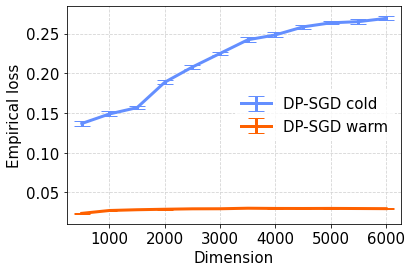

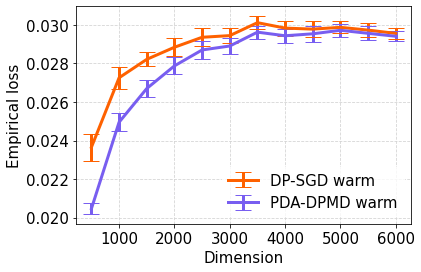

In [ ]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np

DATA_PATH = "/content/drive/MyDrive/MDData/"
results = pickle.load(open(DATA_PATH+"LinRegResults.p", "rb"))
pubresults = results[0]
csgdresults = results[1]
wsgdresults = results[2] 
mdresults = results[3]
npresults = results[4] 
print([r[0] for r in mdresults])

dims = sorted(list(set([r[0] for r in mdresults])))
cmeans = list()
cerr = list()
wmeans = list()
werr = list()
mmeans = list()
merr = list()
for dim in dims:
    cr = [r[1] for r in csgdresults if r[0] == dim]
    wr = [r[1] for r in wsgdresults if r[0] == dim]
    mr = [r[1] for r in mdresults if r[0] == dim]
    cmeans.append(np.mean(cr))
    cerr.append(1.96*np.std(cr)/(len(cr)**0.5))
    wmeans.append(np.mean(wr))
    werr.append(1.96*np.std(wr)/(len(wr)**0.5))
    mmeans.append(np.mean(mr))
    merr.append(1.96*np.std(mr)/(len(mr)**0.5))

plt.rcParams.update({'font.size': 15})
capsize = 8
plt.clf()
plt.errorbar(x = dims, y = cmeans, yerr = cerr, label = "DP-SGD cold", capsize = capsize, color = '#648FFF', linewidth = 3)
plt.errorbar(x = dims, y = wmeans, yerr = werr, label = "DP-SGD warm", capsize = capsize, color = '#FE6100', linewidth = 3)
plt.grid(color='#d4d4d4', linestyle='--')
plt.xlabel("Dimension")
plt.ylabel("Empirical loss")
plt.legend(edgecolor='1')
plt.savefig("SyntheticLinRegResults1.pdf")
plt.show()

plt.clf()
plt.errorbar(x = dims, y = wmeans, yerr = werr, label = "DP-SGD warm", capsize = capsize, color = '#FE6100', linewidth = 3)
plt.errorbar(x = dims, y = mmeans, yerr = merr, label = "PDA-DPMD warm", capsize = capsize, color = '#785EF0', linewidth = 3)
plt.grid(color='#d4d4d4', linestyle='--')
plt.xlabel("Dimension")
plt.ylabel("Empirical loss")
plt.legend(edgecolor='1')
plt.savefig("SyntheticLinRegResults2.pdf")
plt.show()